In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
df = pd.read_csv("/content/IMDB Dataset.csv", engine='python')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [30]:
df.shape

(50000, 2)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [32]:
df['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


In [33]:
df['label'] = df['sentiment'].map({
    'positive':1,
    'negative':0
})
df['label'].value_counts()

,count
label,
1,25000
0,25000


In [34]:
#review length distribution
df['review_length'] = df['review'].apply(len)
df['review_length'].describe()

,review_length
count,50000.000000
mean,1309.431020
std,989.728014
min,32.000000
25%,699.000000
50%,970.000000
75%,1590.250000
max,13704.000000


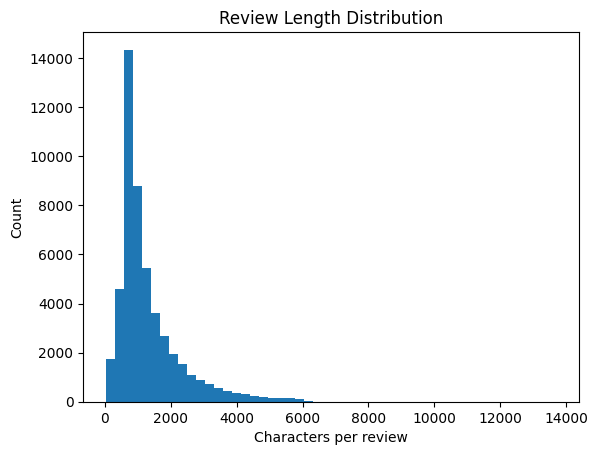

In [35]:
import matplotlib.pyplot as plt

plt.hist(df['review_length'], bins=50)
plt.xlabel("Characters per review")
plt.ylabel("Count")
plt.title("Review Length Distribution")
plt.show()


In [36]:
#sentence tokenization
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [37]:
sample_text = df['review'].iloc[0]
sentences = sent_tokenize(sample_text)
sentences[:3]

["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked.",
 'They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO.',
 'Trust me, this is not a show for the faint hearted or timid.']

In [38]:
from nltk.tokenize import word_tokenize

words = word_tokenize(sentences[0])
words[:20]


['One',
 'of',
 'the',
 'other',
 'reviewers',
 'has',
 'mentioned',
 'that',
 'after',
 'watching',
 'just',
 '1',
 'Oz',
 'episode',
 'you',
 "'ll",
 'be',
 'hooked',
 '.']

Text Cleaning

In [39]:
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
def clean_text(text):
  text = text.lower()
  text = re.sub(r'<.*?>', '', text)      # remove HTML
  text = re.sub(r'[^a-z\s]', '', text)   # remove punctuation
  words = text.split()
  words = [word for word in words if word not in stop_words]
  return ' '.join(words)

df['clean_reviews'] = df['review'].apply(clean_text)
df[['review', 'clean_reviews']].head()

,review,clean_reviews
0,One of the other reviewers has mentioned that ...,one reviewers mentioned watching oz episode yo...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love time money visually stunni...


In [41]:
import sklearn
from sklearn.model_selection import train_test_split

X = df['clean_reviews']
Y = df['label']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)


In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfid = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
#max_features returns only top 5,000 most important tokens (words / phrases)
#ngram_range- ["this movie", "movie is", "is not", "not good", "good at", "at all"]

X_train_tfid = tfid.fit_transform(X_train)
X_test_tfid = tfid.transform(X_test)

Logistic Regression Model

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfid, Y_train)

Y_pred = lr_model.predict(X_test_tfid)
print(classification_report(Y_test, Y_pred))
print(confusion_matrix(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5000
           1       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

[[4395  605]
 [ 509 4491]]


NN Model

In [44]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

nn_model = Sequential([
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn_model.compile(
    optimizer=Adam(0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']

    )

In [45]:
history = nn_model.fit(
    X_train_tfid,
    Y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=256
)

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.7844 - loss: 0.5259 - val_accuracy: 0.8852 - val_loss: 0.2671
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9144 - loss: 0.2233 - val_accuracy: 0.8849 - val_loss: 0.2758
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9303 - loss: 0.1867 - val_accuracy: 0.8774 - val_loss: 0.2889
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.9401 - loss: 0.1667 - val_accuracy: 0.8758 - val_loss: 0.3006
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9497 - loss: 0.1433 - val_accuracy: 0.8741 - val_loss: 0.3201


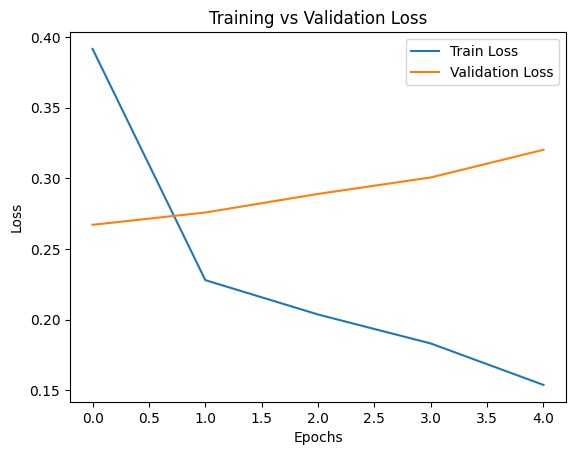

In [46]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [48]:
nn_model.evaluate(X_test_tfid, Y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8754 - loss: 0.3219


[0.32038378715515137, 0.8758000135421753]

In [49]:
Y_test_prob = nn_model.predict(X_test_tfid)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


In [50]:
Y_test_pred = (Y_test_prob >= 0.5).astype(int)

In [51]:
cm = confusion_matrix(Y_test, Y_test_pred)
cm

array([[4358,  642],
       [ 600, 4400]])

In [53]:
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      5000
           1       0.87      0.88      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

